## Sparse logistic regression
$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$

We want to minimize
$$\min_x J(x) := \sum_{i=1}^m \log\bigl(1+\exp (-b_i\lr{a_i, x})\bigr) + \gamma \n{x}_1$$
where $(a_i, b_i)\in \R^n\times \{-1,1\}$ is the training set and $\gamma >0$. We can rewrite the objective as 
$J(x) = \tilde f(Kx)+g(x)$,
where $$\tilde f(y)=\sum_{i=1}^{} \log (1+\exp(y_i)), \quad K = -b*A \in \R^{m\times n}, \quad g(x) = \gamma \n{x}_1$$


In [4]:
import numpy as np
import scipy.linalg as LA
import scipy.sparse as spr
import scipy.sparse.linalg as spr_LA
from time import perf_counter
from sklearn import datasets

In [19]:
filename = "data/a9a"
#filename = "data/real-sim.bz2"
#filename = "data/rcv1_train.binary.bz2"
#filename = "data/kdda.t.bz2"

A, b =  datasets.load_svmlight_file(filename)
m, n = A.shape

print("The dataset {}. The dimensions: m={}, n={}".format(filename[5:], m, n))


# define all ingredients for sparse logistic regression
gamma = 0.005 * LA.norm(A.T.dot(b), np.inf)
K = (A.T.multiply(-b)).T.tocsr()

# find the norm of K^T K
L = spr_LA.svds(K, k=1, return_singular_vectors=False)**2

# starting point
x0 = np.zeros(n)

# stepsize
ss = 4/L


g = lambda x: gamma*LA.norm(x,1)
prox_g = lambda x, rho: x + np.clip(-x, -rho*gamma, rho*gamma)


f = lambda x: np.log(1. + np.exp(x)).sum()

def df(x):
    exp_x = np.exp(x)
    return exp_x/(1.+exp_x)

dh = lambda x, Kx: K.T.dot(df(Kx))

# residual
res = lambda x: LA.norm(x-prox_g(x-dh(x,K.dot(x)), 1))

# energy
J = lambda x, Kx: f(Kx)+g(x)

The dataset a9a. The dimensions: m=32561, n=123


In [20]:
### Algorithms

def prox_grad(x1, s=1, numb_iter=100):
    """
    Implementation of the proximal gradient method.

    x1: array, a starting point
    s: positive number, a stepsize
    numb_iter: positive integer, number of iterations

    Returns an array of energy values, computed in each iteration, and the
    argument x_k after numb_iter iterations
    """
    begin = perf_counter()
    x = x1.copy()
    Kx = K.dot(x)
    values = [J(x, Kx)]
    dhx = dh(x,Kx)

    for i in range(numb_iter):
        #x = prox_g(x - s * dh(x, Kx), s)
        x = prox_g(x - s * dhx, s)
        Kx = K.dot(x)
        dhx = dh(x,Kx)
        values.append(J(x, Kx))

    end = perf_counter()

    print("Time execution of prox-grad:", end - begin)
    return np.array(values), x


def fista(x1, s=1, numb_iter=100):
    """
    Implementation of the FISTA.

    x1: array, a starting point
    s: positive number, a stepsize
    numb_iter: positive integer, number of iterations

    Returns an array of energy values, computed in each iteration, and the
    argument x_k after numb_iter iterations
    """
    begin = perf_counter()
    x, y = x1.copy(), x1.copy()
    t = 1.
    Ky = K.dot(y)
    values = [J(y,Ky)]

    for i in range(numb_iter):
        x1 = prox_g(y - s * dh(y, Ky), s)
        t1 = 0.5 * (1 + np.sqrt(1 + 4 * t**2))
        y = x1 + (t - 1) / t1 * (x1 - x)
        x, t = x1, t1
        Ky = K.dot(y)
        values.append(J(y, Ky))

    end = perf_counter()

    print("Time execution of FISTA:", end - begin)
    return np.array(values), x


def adaptive_graal(x1, numb_iter=100):
    """
    Implementation of the adaptive GRAAL.

    x1: array, a starting point
    numb_iter: positive integer, number of iterations

    Returns an array of energy values, computed in each iteration, and the
    argument x_k after numb_iter iterations
    """
    begin = perf_counter()
    phi = 1.5
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Kx = K.dot(x)
    dhx = dh(x, Kx)
    la = phi / 2 * LA.norm(x - x0) / LA.norm(dhx - dh(x0, K.dot(x0)))
    rho = 1. / phi + 1. / phi**2
    values = [J(x, Kx)]
    th = 1

    for i in range(numb_iter):
        x1 = prox_g(x_ - la * dhx, la)
        Kx1 = K.dot(x1)
        dhx1 = dh(x1, Kx1)

        n1 = LA.norm(x1 - x)**2
        n2 = LA.norm(dhx1 - dhx)**2

        n1_div_n2 = n1/n2 if n2 != 0 else la*10
        la1 = min(rho * la, 0.25 * phi * th / la * (n1_div_n2))
        x_ = ((phi - 1) * x1 + x_) / phi
        th = phi * la1 / la
        x, la, dhx = x1, la1, dhx1
        values.append(J(x1, Kx1))

    end = perf_counter()

    print("Time execution of aGRAAL:", end - begin)
    return values, x, x_


Run the algorithms. It might take some time, if the dataset and/or the number of iterations are huge

In [21]:
N = 10000
ans1 = prox_grad(x0, ss, numb_iter=N)
ans2 = fista(x0, ss, numb_iter=N)
ans3 = adaptive_graal(x0,  numb_iter=N)

x1, x2, x3 = ans1[1], ans2[1], ans3[1]
x1, x3 = ans1[1], ans3[1]
print("Residuals:", [res(x) for x in [x1, x2, x3]])

Time execution of prox-grad: 68.03384687801008
Time execution of FISTA: 68.20270787499612
Time execution of aGRAAL: 70.1420427080011
Residuals: [4.084755911350097e-05, 6.0765061701526585e-06, 7.583397935460372e-10]


Plot the results

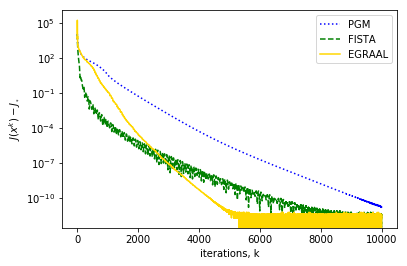

In [22]:
values = [ans1[0], ans2[0], ans3[0]]
labels = ["PGM", "FISTA", "aGRAAL"]
linestyles = [':', "--", "-"]
colors = ['b', 'g', '#FFD700']

v_min = min([min(v) for v in values])
plt.figure(figsize=(6,4))
for i,v in enumerate(values):
    plt.plot(v - v_min, color=colors[i], label=labels[i], linestyle=linestyles[i])
plt.yscale('log')
plt.xlabel(u'iterations, k')
plt.ylabel('$J(x^k)-J_{_*}$')
plt.legend()
#plt.savefig('figures/a9a.pdf', bbox_inches='tight')
plt.show()


plt.clf()


In [10]:
np.max(spr_LA.eigsh(K.T.dot(K))[0])

204733.10930555634

In [11]:
L

array([ 204733.10930556])